In [65]:
import pennylane as qml
from pennylane import numpy as np

import scipy as sp

import matplotlib.pyplot as plt

# 2-qubit
dev = qml.device('default.mixed', wires= 2)

# == Hamiltonian setup == 
# coeffs = [1e+15]
coeffs = [1, 1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1), qml.PauliZ(0) @ qml.PauliZ(1)]

hamiltonian = qml.Hamiltonian(coeffs, obs)
# print('Hamiltonian:\n', hamiltonian)

In [66]:
# == Generate circuit == 

# global var
Paras_global = None
Phi_global = None

# Entnalger 
@qml.qnode(dev)
def circuit_1(paras):
    theta_init, tau_1, tau_2 = paras
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, tau_1, 1)
    qml.RX(theta_init, wires = 0)    
    qml.RX(theta_init, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, tau_2, 1)

    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    return qml.density_matrix(wires=[0, 1])


@qml.qnode(dev)
def circuit_2(phi):
    global Paras_global
    # == type casting requried? ==
    density_matrix = circuit_1(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires=[0, 1])
    
    # Stage_3: Accumulater
    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.RX(np.pi/2, wires=0)
    qml.RX(np.pi/2, wires=1)
    
    return qml.probs(wires=[0, 1])

@qml.qnode(dev)
def circuit_graphic():
    
   # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, 1, 1)
    qml.RX(1, wires = 0)    
    qml.RX(1, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, 1, 1)

    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulater
    qml.ApproxTimeEvolution(hamiltonian, 1, 1)
    qml.RX(np.pi/2, wires=0)
    qml.RX(np.pi/2, wires=1)
    
    return qml.probs(wires=[0, 1])

In [67]:
Paras_global = 1e-10, 1e-10, 1
phi_global = 1

mem = np.array([1])
temp = qml.qinfo.classical_fisher(circuit_2)(mem[0])

temp

tensor([[1.35585468e-30]], requires_grad=True)

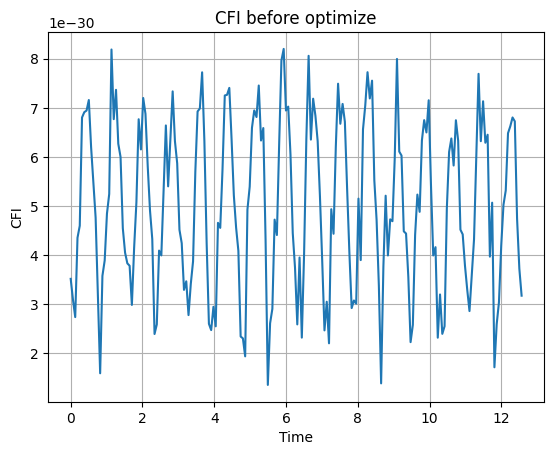

In [68]:
# == Sweep phi for range ==
Select_bound = np.array([0 + 1e-4, np.pi * 4 + 1e-4])
N = 200

# Searching range array
Phi_range = np.linspace(Select_bound[0], Select_bound[1], N)
Sweep_data = np.zeros(len(Phi_range))

# Select initial paras for entanglers
Paras_global = 1, 1, 1/2
for i in range(len(Phi_range)):
    Sweep_data[i] = qml.qinfo.classical_fisher(circuit_2)(Phi_range[i])

# Plot CFI_before
plt.plot(Phi_range, Sweep_data)
plt.title('CFI before optimize')
plt.xlabel('Time')
plt.ylabel('CFI')
# plt.legend()
plt.grid()

# Sweep_data

In [69]:
H = np.array([ [1.0, -0.5], [-0.5, -1.0] ])


def func(H, t):
    return sp.linalg.expm(H * t)


func(H, 0.5)


array([[ 1.68681324, -0.2632258 ],
       [-0.2632258 ,  0.63391002]])